This jupyter notebook contains some of the codes and calculations associated with our recent paper: "The VLT-MUSE and ALMA view of the MACS 1931.8-2635 brightest cluster galaxy" -Ciocan B. I. , Ziegler, B. L. , Verdugo, M. , Papaderos, P. , Fogarty, K. , Donahue, M. , and Postman, M.

## Extract from your MUSE data cube each spaxel as a spectrum in order to run the the FADO pipeline (Gomes & Papaderos 2017) on the data set

In [1]:
import mpdaf
from mpdaf.obj import Cube, Spectrum, WaveCoord,deg2sexa, iter_spe
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS

Upload your data-cube

In [2]:
cube = Cube('/Users/biancaciocan/Documents/M1931_BCG_PROJECT/M1931_results_FADO_python/DATACUBE_FINAL_stacked_pycombine.fits', ext=[1,2])


We are interested only in the most central region of the MUSE data cube, corresponding to the position of the BCG, so let's extrct a sub-cube

In [3]:
sub_cube = cube.subcube_circle_aperture(center=(-26.5761075,292.9568383), radius=9)

Let's look at the white-light image of the sub-cube

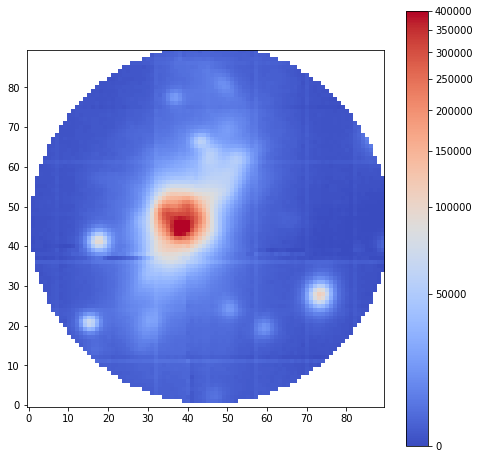

In [4]:
plt.figure(figsize=(8,8))
ima = sub_cube.sum(axis=0)
ima.write("subcube_BCG_MACSJ1931_image_original.fits")
cm=plt.cm.get_cmap('coolwarm')
ax=ima.plot(scale='arcsinh', cmap=cm, vmin=0, vmax=400000) 
cbar=plt.colorbar(ax)

Now let's look at the spectrum

Text(0, 0.5, 'Flux $[10^{-20}\\:\\frac{erg}{s \\cdot cm^2 \\cdot \\AA} ]$')

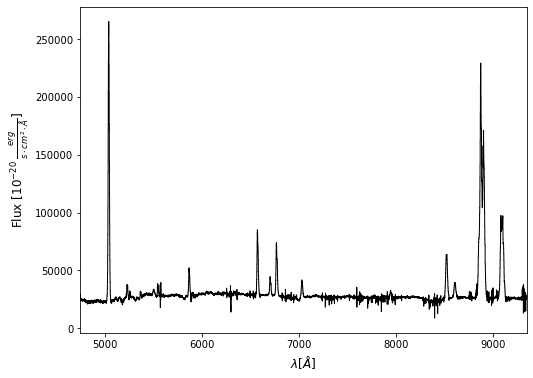

In [10]:
spe=sub_cube.sum(axis=(1,2))

plt.figure(figsize=(8,6))
spe.plot(color='black')
plt.xlabel(r'$\lambda [\AA]$',fontsize=12)
plt.ylabel(r'Flux $[10^{-20}\:\frac{erg}{s \cdot cm^2 \cdot \AA} ]$',fontsize=12)

Now we want to extract each spaxel of the data-cube as a spectrum (and also write a table containing the names of each spaxel so we provide it as a list in order to run FADO)

In [ ]:
with open('spectra_lis.txt',"w+") as f:
	f.write('# list spectra for FADO \n')

	for sp,pos in iter_spe(sub_cube, index=True):
		p,q = pos
		spe = sub_cube[:, p, q]
		Spectrum.write(spe, filename='spec_p'+str(p)+'q'+str(q)+'.fits', savemask='dq', checksum=False)
		# we also need to change the fist format
		hdu = fits.open('spec_p'+str(p)+'q'+str(q)+'.fits')
		data = hdu[1].data
		head = hdu[1].header
		stats = hdu[2].data

		Nhdu1=fits.PrimaryHDU(data=data, header=head)
		Nhdu2=fits.ImageHDU(data=stats, header=head, name="VARIANCE")
	
		hdulist = fits.HDUList([Nhdu1,Nhdu2])
		hdulist.writeto('spec_wcs1d_p'+str(p)+'q'+str(q)+'.fits',overwrite=True)
		
		f.write('spec_wcs1d_p'+str(p)+'q'+str(q)+'.fits \n')

#this procedure will take up to half an hour, given that there are ~ 8100 spectra to be extracted

After extracting all the spectra, correct them for Galactic foreground extinction with the noao onedspec deredden IRAF routine, using the empirical selective extinction function of Cardelli et al. (1989).